- https://levelup.gitconnected.com/python-for-trading-how-i-used-classification-algorithms-to-easily-enhance-my-winning-rate-by-22-4-6269167fbf93
- https://levelup.gitconnected.com/how-i-used-mathematics-and-ai-to-increase-my-profits-by-22-4-part2-89cd1443fa56
- https://levelup.gitconnected.com/passive-income-with-profitable-machine-learning-algorithm-7788e06c7618

In [6]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Technical indicator library
import talib as ta

# Data import library
import yfinance as yf

#Data visualisation
import plotly.graph_objs as go

from binance.client import Client
from binance.enums import HistoricalKlinesType

In [12]:
api_key = 'y9m94JvyDsSRyHZUQjNN1lVfDnduNMFyQxz83EW650XKwgbIXxB85xGv7CDQfW8Z'
api_secret = 'cHvzTpnE3Qp468ZcAIadtIQSKvV6HdbXsnwbTAhlTCg9Q0uydcxVKUwP7rqLrcpl'

klines_column_names = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 
                       'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

client = Client(api_key, api_secret, {"timeout": 60})

##  Get Data

In [ ]:
#Download live data
df = yf.download('TSLA',period = '1d', interval = '1m')
df

In [65]:
start_date = '1 March, 2022'
end_date = '4 March, 2022'

In [66]:
klines = client.get_historical_klines(symbol = "ETHUSDT", 
                             interval = Client.KLINE_INTERVAL_1MINUTE, 
                             start_str = start_date,
                             end_str = end_date,
                             klines_type = HistoricalKlinesType.FUTURES)

In [67]:
df_klines = pd.DataFrame(klines, columns=klines_column_names).set_index('Open time')
df_klines.index = pd.to_datetime(df_klines.index, unit='ms')
df_klines = df_klines.astype({'Open':'double', 'High':'double', 'Low':'double', 'Close':'double', 'Volume': 'double'})

df = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]

In [68]:

#declare figure
fig = go.Figure()

#Set up traces
fig.add_trace(go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Tesla price',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="30m", step="minute", stepmode="backward"),
            dict(count=6, label="90m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(step="all")
        ])
    )
)

fig.show()


## Data Cleaning & Preparation

In [69]:
df = df[df.Volume!=0]

In [70]:
# Create a variable n with a value of 10
n = 10
# Create a column by name, RSI and assign the calculation of RSI to it
df['RSI'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)

# Create a column by name, SMA and assign the SMA calculation to it
df['SMA'] = df['Close'].shift(1).rolling(window=n).mean()

# Create a column by name, Corr and assign the calculation of correlation to it
df['Corr'] = df['Close'].shift(1).rolling(window=n).corr(df['SMA'].shift(1))

# Create a column by name, SAR and assign the SAR calculation to it
df['SAR'] = ta.SAR(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)),
                   0.2, 0.2)

# Create a column by name, ADX and assign the ADX calculation to it
df['ADX'] = ta.ADX(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)),
                   np.array(df['Open']), timeperiod=n)

# Create columns high, low and close with previous minute's OHLC data
df['Prev_High'] = df['High'].shift(1)
df['Prev_Low'] = df['Low'].shift(1)
df['Prev_Close'] = df['Close'].shift(1)

# Create columns 'OO' with the difference between the current minute's open and last minute's open
df['OO'] = df['Open']-df['Open'].shift(1)

# Create columns 'OC' with the difference between the current minute's open and last minute's close
df['OC'] = df['Open']-df['Prev_Close']

# Create a column 'Ret' with the calculation of returns
df['Ret'] = (df['Open'].shift(-1)-df['Open'])/df['Open']

# Create n columns and assign
for i in range(1, n):
    df['return%i' % i] = df['Ret'].shift(i)

df.head()

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,...,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
Open time,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,2920.05,2922.09,2919.03,2920.44,1661.919,NaN,NaN,NaN,NaN,NaN,...,0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:01:00,2920.44,2929.00,2919.52,2927.53,3525.497,NaN,NaN,NaN,NaN,NaN,...,0.002428,0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:02:00,2927.53,2948.84,2927.53,2946.99,11660.368,NaN,NaN,NaN,2919.03,NaN,...,0.006651,0.002428,0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:03:00,2947.00,2950.85,2937.10,2938.03,16674.483,NaN,NaN,NaN,2919.52,NaN,...,-0.003040,0.006651,0.002428,0.000134,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:04:00,2938.04,2954.53,2938.04,2952.32,8065.696,NaN,NaN,NaN,2919.52,NaN,...,0.004816,-0.003040,0.006651,0.002428,0.000134,NaN,NaN,NaN,NaN,NaN


In [71]:
# Change the value of 'Corr' to -1 if it is less than -1
df.loc[df['Corr'] < -1, 'Corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
df.loc[df['Corr'] > 1, 'Corr'] = 1

# Drop the NaN values
df = df.dropna()

In [72]:
# Create a variable split that stores 80% of the length of the dataframe
t = .8
split = int(t*len(df))
print('Train Size : ', split)
print('Test Size : ', len(df) - split)

Train Size :  3440
Test Size :  860


In [73]:
# Create a column by name, 'Signal' and initialize with 0
df['Signal'] = 0

# Assign a value of 1 to 'Signal' column for the quantile with the highest returns
df.loc[df['Ret'] > df['Ret'][:split].quantile(q=0.66), 'Signal'] = 1

# Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
df.loc[df['Ret'] < df['Ret'][:split].quantile(q=0.34), 'Signal'] = -1

## Training

In [74]:
# Use drop method to drop the columns
X = df.drop(['Low', 'High', 'Close', 'Signal', 'Ret'], axis=1)

# Create a variable which contains all the 'Signal' values
y = df['Signal']

In [75]:
X

,Open,Volume,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,...,OC,return1,return2,return3,return4,return5,return6,return7,return8,return9
Open time,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:20:00,2938.68,4067.707,49.827977,2951.717,-0.664100,2952.607930,39.495081,2941.49,2932.97,2938.68,...,0.00,0.001899,-0.003496,-0.000981,-0.001352,-0.002492,0.000101,-0.002294,-0.002175,0.005300
2022-03-01 00:21:00,2942.61,1875.470,52.832887,2950.484,-0.874127,2948.578344,36.175890,2944.90,2937.53,2942.62,...,-0.01,0.001337,0.001899,-0.003496,-0.000981,-0.001352,-0.002492,0.000101,-0.002294,-0.002175
2022-03-01 00:22:00,2941.71,1594.832,51.981260,2947.552,-0.736709,2945.354675,32.990617,2942.62,2936.71,2941.65,...,0.06,-0.000306,0.001337,0.001899,-0.003496,-0.000981,-0.001352,-0.002492,0.000101,-0.002294
2022-03-01 00:23:00,2939.11,883.083,49.652596,2945.048,-0.146269,2944.900000,29.993865,2941.72,2936.21,2939.11,...,0.00,-0.000884,-0.000306,0.001337,0.001899,-0.003496,-0.000981,-0.001352,-0.002492,0.000101
2022-03-01 00:24:00,2939.81,2101.246,50.343501,2943.296,0.159398,2942.620000,27.026196,2940.00,2935.00,2939.82,...,-0.01,0.000238,-0.000884,-0.000306,0.001337,0.001899,-0.003496,-0.000981,-0.001352,-0.002492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-03 23:55:00,2834.45,149.536,44.207623,2834.506,0.335050,2830.570000,27.529433,2835.98,2834.14,2834.44,...,0.01,-0.000194,0.001003,-0.000304,-0.000469,0.000004,0.000399,-0.000166,-0.001452,0.000257
2022-03-03 23:56:00,2831.99,134.833,36.957317,2834.003,0.392322,2831.650000,27.648928,2834.45,2831.72,2831.99,...,0.00,-0.000868,-0.000194,0.001003,-0.000304,-0.000469,0.000004,0.000399,-0.000166,-0.001452
2022-03-03 23:57:00,2832.66,278.039,39.992368,2833.489,0.280931,2831.720000,27.756474,2833.09,2831.99,2832.67,...,-0.01,0.000237,-0.000868,-0.000194,0.001003,-0.000304,-0.000469,0.000004,0.000399,-0.000166


In [76]:
x_train = X[:split]
y_train = y[:split]

x_test = X[split:]
y_test = y[split:]

In [77]:
# Test variables for 'c' and 'g'
#Setting the different values to test within C, Gamma and Kernel
c = np.logspace(1, 4, 5)
g = np.logspace(1, -4, 5)

# Intialise the parameters
parameters = {'svc__C': c,
              'svc__gamma': g,
              'svc__kernel': ['rbf']
              }

#Creating the step by step pipeline
# Create the 'steps' variable with the pipeline functions
# Pass the 'steps' to the Pipeline function
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(verbose=1))])

#Creating a randomized function to help to find the best parameters.
# Call the RandomizedSearchCV function and pass the parameters
rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2), verbose=1)

In [78]:
# Call the 'fit' method of rcv and pass the train data to it
rcv.fit(x_train, y_train)

# Call the 'best_params_' method to obtain the best parameters of C
best_C = rcv.best_params_['svc__C']

# Call the 'best_params_' method to obtain the best parameters of kernel
best_kernel = rcv.best_params_['svc__kernel']

# Call the 'best_params_' method to obtain the best parameters of gamma
best_gamma = rcv.best_params_['svc__gamma']

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

3Day, 5Day : {'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 10000.0}

In [79]:
rcv.best_params_

{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 10000.0}

In [80]:
# Create a new SVC classifier
cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

# Instantiate the StandardScaler
ss1 = StandardScaler()

# Pass the scaled train data to the SVC classifier
cls.fit(ss1.fit_transform(x_train), y_train)

# Pass the test data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(x_train))

In [81]:
# Calculate the confusion matrix
print(confusion_matrix(y_train, y_predict))

# Calculate the classification report
cr = classification_report(y_train, y_predict)
print(cr)

[[373 522 275]
 [145 817 138]
 [265 495 410]]
              precision    recall  f1-score   support

          -1       0.48      0.32      0.38      1170
           0       0.45      0.74      0.56      1100
           1       0.50      0.35      0.41      1170

    accuracy                           0.47      3440
   macro avg       0.47      0.47      0.45      3440
weighted avg       0.47      0.47      0.45      3440



In [82]:
y_predict = cls.predict(ss1.transform(x_test))

# Calculate the confusion matrix
print(confusion_matrix(y_test, y_predict))

# Calculate the classification report
cr = classification_report(y_test, y_predict)
print(cr)

[[ 25 180  81]
 [ 12 255  41]
 [ 15 162  89]]
              precision    recall  f1-score   support

          -1       0.48      0.09      0.15       286
           0       0.43      0.83      0.56       308
           1       0.42      0.33      0.37       266

    accuracy                           0.43       860
   macro avg       0.44      0.42      0.36       860
weighted avg       0.44      0.43      0.37       860



In [83]:
# Initiate a column by name, 'Pred_Signal' and assign 0 to it
df['Pred_Signal'] = 0

# Save the predicted values for the train data
df.iloc[:split, df.columns.get_loc('Pred_Signal')] = pd.Series(
    cls.predict(ss1.transform(x_train)).tolist())

# Save the predicted values for the test data
df.iloc[split:, df.columns.get_loc('Pred_Signal')] = y_predict

# Calculate strategy returns and store them in 'Ret1' column
df['Ret1'] = df['Ret']*df['Pred_Signal']

In [84]:
df[['Ret', 'Ret1', 'Pred_Signal']].tail(50)

,Ret,Ret1,Pred_Signal
Open time,,,
2022-03-03 23:10:00,0.000685,0.0,0
2022-03-03 23:11:00,-0.000049,-0.0,0
2022-03-03 23:12:00,0.000498,0.0,0
2022-03-03 23:13:00,0.001178,0.0,0
2022-03-03 23:14:00,0.000814,0.0,0
2022-03-03 23:15:00,0.000165,0.0,0
2022-03-03 23:16:00,-0.000521,-0.0,0
2022-03-03 23:17:00,0.000007,0.0,0
2022-03-03 23:18:00,0.000271,0.0,0


In [85]:
#declare figure
fig = go.Figure()

#Set up traces
fig.add_trace(go.Scatter(x=df.index, y=(df['Ret'][split:]+1).cumprod(),line=dict(color='royalblue', width=.8), name = 'stock_returns'))
fig.add_trace(go.Scatter(x=df.index, y=(df['Ret1'][split:]+1).cumprod(),line=dict(color='orange', width=.8), name = 'strategy_returns'))

# Add titles
fig.update_layout(
    title='Support Vector Machine Strategy',
    yaxis_title='Stock return (% Return)')

fig.show()

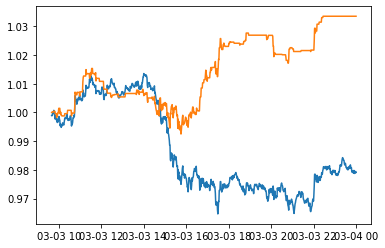

In [86]:
plt.plot((df['Ret'][split:]+1).cumprod())
plt.plot((df['Ret1'][split:]+1).cumprod())

## Real Time test

In [96]:
start_date = '15 March, 2022'
end_date = '16 March, 2022'

In [97]:
klines = client.get_historical_klines(symbol = "ETHUSDT", 
                             interval = Client.KLINE_INTERVAL_1MINUTE, 
                             start_str = start_date,
                             end_str = end_date,
                             klines_type = HistoricalKlinesType.FUTURES)

In [98]:
df_klines = pd.DataFrame(klines, columns=klines_column_names).set_index('Open time')
df_klines.index = pd.to_datetime(df_klines.index, unit='ms')
df_klines = df_klines.astype({'Open':'double', 'High':'double', 'Low':'double', 'Close':'double', 'Volume': 'double'})

df = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]

In [99]:
df = df[df.Volume!=0]

# Create a variable n with a value of 10
n = 10
# Create a column by name, RSI and assign the calculation of RSI to it
df['rsi'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)

# Create a column by name, SMA and assign the SMA calculation to it
df['sma'] = df['Close'].shift(1).rolling(window=n).mean()

# Create a column by name, Corr and assign the calculation of correlation to it
df['corr'] = df['Close'].shift(1).rolling(window=n).corr(df['sma'].shift(1))

# Create a column by name, SAR and assign the SAR calculation to it
df['sar'] = ta.SAR(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)),
                   0.2, 0.2)

# Create a column by name, ADX and assign the ADX calculation to it
df['adx'] = ta.ADX(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)),
                   np.array(df['Open']), timeperiod=n)

# Create columns high, low and close with previous minute's OHLC data
df['prev_high'] = df['High'].shift(1)
df['prev_low'] = df['Low'].shift(1)
df['prev_close'] = df['Close'].shift(1)

# Create columns 'OO' with the difference between the current minute's open and last minute's open
df['open_prevopen_diff'] = df['Open']-df['Open'].shift(1)

# Create columns 'OC' with the difference between the current minute's open and last minute's close
df['open_prevclose_diff'] = df['Open']-df['Prev_Close']

# Create a column 'Ret' with the calculation of returns
df['Ret'] = (df['Open'].shift(-1)-df['Open'])/df['Open']

# Create n columns and assign
for i in range(1, n):
    df['return%i' % i] = df['Ret'].shift(i)

df.head()

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,...,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
Open time,,,,,,,,,,,,,,,,,,,,,
2022-03-15 00:00:00,2588.96,2591.81,2587.16,2589.90,2734.752,NaN,NaN,NaN,NaN,NaN,...,0.000359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 00:01:00,2589.89,2592.75,2589.65,2591.70,1554.456,NaN,NaN,NaN,NaN,NaN,...,0.000699,0.000359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 00:02:00,2591.70,2593.68,2588.01,2592.30,3479.216,NaN,NaN,NaN,2587.16,NaN,...,0.000243,0.000699,0.000359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 00:03:00,2592.33,2598.27,2592.07,2594.31,6082.751,NaN,NaN,NaN,2593.68,NaN,...,0.000760,0.000243,0.000699,0.000359,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 00:04:00,2594.30,2594.99,2590.03,2592.14,3197.191,NaN,NaN,NaN,2588.01,NaN,...,-0.000836,0.000760,0.000243,0.000699,0.000359,NaN,NaN,NaN,NaN,NaN


In [100]:
# Change the value of 'Corr' to -1 if it is less than -1
df.loc[df['corr'] < -1, 'corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
df.loc[df['corr'] > 1, 'corr'] = 1

# Drop the NaN values
df = df.dropna()

In [101]:
predict = cls.predict(ss1.transform(df.drop(['High', 'Low', 'Close', 'Ret'], axis=1)))

In [102]:
# Initiate a column by name, 'Pred_Signal' and assign 0 to it
df['pred_signal'] = 0

# Save the predicted values for the test data
df['pred_signal'] = predict

# Calculate strategy returns and store them in 'Ret1' column
df['Ret1'] = df['Ret']*df['pred_signal']

In [103]:
#declare figure
fig = go.Figure()

#Set up traces
fig.add_trace(go.Scatter(x=df.index, y=(df['Ret']+1).cumprod(),line=dict(color='royalblue', width=.8), name = 'stock_returns'))
fig.add_trace(go.Scatter(x=df.index, y=(df['Ret1']+1).cumprod(),line=dict(color='orange', width=.8), name = 'strategy_returns'))

# Add titles
fig.update_layout(
    title='Support Vector Machine Strategy',
    yaxis_title='Stock return (% Return)')

fig.show()

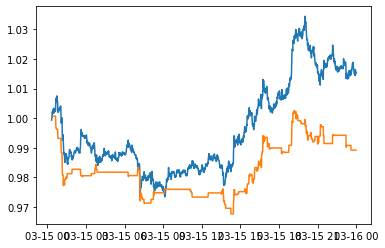

In [104]:
plt.plot((df['Ret']+1).cumprod())
plt.plot((df['Ret1']+1).cumprod())